In [41]:
# !pip install pandas transformers scikit-learn matplotlib seaborn sentencepiece accelerate -q
# !pip install protobuf

# import pandas as pd
# hate_yes_data = pd.read_csv('/root/ccs_aisf/data/yes_no/hate_vs_antagonist_yes.csv')
# hate_no_data = pd.read_csv('/root/ccs_aisf/data/yes_no/hate_vs_antagonist_no.csv')

# torch.set_default_tensor_type(torch.cuda.HalfTensor)

## **1. Datasets.**

In [42]:
import re
import pickle
import pandas as pd
from sklearn.metrics import accuracy_score
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification
# from transformers import EncoderDecoderModel, BertTokenizer, DistilBertTokenizer
# from transformers import AutoModelForCausalLM

from sklearn.linear_model import LogisticRegression
import numpy as np
from tqdm import tqdm

import sys
import os

# Add the code directory directly to Python path
code_dir = '/Users/elenaericheva/ericheva_git/ccs_aisf/code'
if code_dir not in sys.path:
    sys.path.insert(0, code_dir)

print(f"Added {code_dir} to Python path")

Added /Users/elenaericheva/ericheva_git/ccs_aisf/code to Python path


## **2. Choose model.**

In [43]:
"""
T5 Gemma – encoder‑decoder (Seq2Seq)
-----------------------------------
We loop over every HF ID so you can pick ’n mix or just run them all.
"""

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Every official checkpoint ➜ comment explains what it is
T5GEMMA_CHECKPOINTS = {
    # -------- 2 B encoder · 2 B decoder --------
    "google/t5gemma-2b-2b-ul2":        "# 2B‑2B · UL2 pre‑training",
    "google/t5gemma-2b-2b-ul2-it":     "# 2B‑2B · UL2 · instruction‑tuned",
    "google/t5gemma-2b-2b-prefixlm":   "# 2B‑2B · PrefixLM pre‑training",
    "google/t5gemma-2b-2b-prefixlm-it":"# 2B‑2B · PrefixLM · instruction‑tuned",

    # -------- 9 B encoder · 2 B decoder --------
    "google/t5gemma-9b-2b-ul2":        "# 9B‑2B · UL2",
    "google/t5gemma-9b-2b-ul2-it":     "# 9B‑2B · UL2 · IT",
    "google/t5gemma-9b-2b-prefixlm":   "# 9B‑2B · PrefixLM",
    "google/t5gemma-9b-2b-prefixlm-it":"# 9B‑2B · PrefixLM · IT",

    # -------- 9 B encoder · 9 B decoder --------
    "google/t5gemma-9b-9b-ul2":        "# 9B‑9B · UL2",
    "google/t5gemma-9b-9b-ul2-it":     "# 9B‑9B · UL2 · IT",
    "google/t5gemma-9b-9b-prefixlm":   "# 9B‑9B · PrefixLM",
    "google/t5gemma-9b-9b-prefixlm-it":"# 9B‑9B · PrefixLM · IT",

    # -------- Classic T5 size grid, Gemma recipe --------
    # Small (≈0.3 B)
    "google/t5gemma-s-s-ul2":          "# T5‑Small · UL2",
    "google/t5gemma-s-s-ul2-it":       "# T5‑Small · UL2 · IT",
    "google/t5gemma-s-s-prefixlm":     "# T5‑Small · PrefixLM",
    "google/t5gemma-s-s-prefixlm-it":  "# T5‑Small · PrefixLM · IT",

    # Base (≈0.6 B)
    "google/t5gemma-b-b-ul2":          "# T5‑Base · UL2",
    "google/t5gemma-b-b-ul2-it":       "# T5‑Base · UL2 · IT",
    "google/t5gemma-b-b-prefixlm":     "# T5‑Base · PrefixLM",
    "google/t5gemma-b-b-prefixlm-it":  "# T5‑Base · PrefixLM · IT",

    # Large (≈1 B)
    "google/t5gemma-l-l-ul2":          "# T5‑Large · UL2",
    "google/t5gemma-l-l-ul2-it":       "# T5‑Large · UL2 · IT",
    "google/t5gemma-l-l-prefixlm":     "# T5‑Large · PrefixLM",
    "google/t5gemma-l-l-prefixlm-it":  "# T5‑Large · PrefixLM · IT",

    # Multi‑Large (≈2 B)
    "google/t5gemma-ml-ml-ul2":        "# T5‑ML · UL2",
    "google/t5gemma-ml-ml-ul2-it":     "# T5‑ML · UL2 · IT",
    "google/t5gemma-ml-ml-prefixlm":   "# T5‑ML · PrefixLM",
    "google/t5gemma-ml-ml-prefixlm-it":"# T5‑ML · PrefixLM · IT",

    # XL (≈4 B)
    "google/t5gemma-xl-xl-ul2":        "# T5‑XL · UL2",
    "google/t5gemma-xl-xl-ul2-it":     "# T5‑XL · UL2 · IT",
    "google/t5gemma-xl-xl-prefixlm":   "# T5‑XL · PrefixLM",
    "google/t5gemma-xl-xl-prefixlm-it":"# T5‑XL · PrefixLM · IT",
}

YOUR_NAME = "t5gemma-9b-9b-ul2"
print(f"\nLoading {"google/" + YOUR_NAME}")
tokenizer = AutoTokenizer.from_pretrained("google/" + YOUR_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(
    "google/" + YOUR_NAME,
    torch_dtype=torch.bfloat16,   # or "auto"
).to("cpu")
model.eval()                     # inference‑only by default



Loading google/t5gemma-9b-9b-ul2


Loading checkpoint shards: 100%|██████████| 9/9 [00:00<00:00, 79.00it/s]


T5GemmaForConditionalGeneration(
  (model): T5GemmaModel(
    (encoder): T5GemmaEncoder(
      (embed_tokens): Embedding(256000, 3584, padding_idx=0)
      (norm): T5GemmaRMSNorm((3584,), eps=1e-06)
      (rotary_emb): T5GemmaRotaryEmbedding()
      (layers): ModuleList(
        (0-41): 42 x T5GemmaEncoderLayer(
          (self_attn): T5GemmaSelfAttention(
            (q_proj): Linear(in_features=3584, out_features=4096, bias=False)
            (k_proj): Linear(in_features=3584, out_features=2048, bias=False)
            (v_proj): Linear(in_features=3584, out_features=2048, bias=False)
            (o_proj): Linear(in_features=4096, out_features=3584, bias=False)
          )
          (pre_self_attn_layernorm): T5GemmaRMSNorm((3584,), eps=1e-06)
          (post_self_attn_layernorm): T5GemmaRMSNorm((3584,), eps=1e-06)
          (mlp): T5GemmaMLP(
            (gate_proj): Linear(in_features=3584, out_features=14336, bias=False)
            (up_proj): Linear(in_features=3584, out_features=

## **4. Plot.**

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from itertools import combinations
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

In [45]:
import pandas as pd

# Load data
hate_data = pd.read_csv('../data/raw/total_hate_data.csv', index_col=0)

# Check token lengths
token_lengths = []
for text in hate_data['statement']:
    if text and isinstance(text, str):
        tokens = tokenizer(text, return_tensors="pt")
        token_lengths.append(tokens['input_ids'].shape[1])

# Results
print(f"Max tokens: {max(token_lengths)}")
print(f"95th percentile: {int(sorted(token_lengths)[int(0.95 * len(token_lengths))])}")
print(f"90th percentile: {int(sorted(token_lengths)[int(0.90 * len(token_lengths))])}")
print(f"Mean tokens: {int(sum(token_lengths) / len(token_lengths))}")

# Load data
hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)

# Check token lengths
token_lengths = []
for text in hate_data['statement']:
    if text and isinstance(text, str):
        tokens = tokenizer(text, return_tensors="pt")
        token_lengths.append(tokens['input_ids'].shape[1])

# Results
print(f"Max tokens: {max(token_lengths)}")
print(f"95th percentile: {int(sorted(token_lengths)[int(0.95 * len(token_lengths))])}")
print(f"90th percentile: {int(sorted(token_lengths)[int(0.90 * len(token_lengths))])}")
print(f"Mean tokens: {int(sum(token_lengths) / len(token_lengths))}")

Max tokens: 32
95th percentile: 18
90th percentile: 15
Mean tokens: 9
Max tokens: 25
95th percentile: 17
90th percentile: 14
Mean tokens: 9


In [46]:
import torch
import pandas as pd
import numpy as np
from extract_fixed_t5gemma9b import vectorize_df_batched
from format_results_fixed import plot_pca_or_tsne_layerwise


# ──────────────────────────────────────────────────────────────────────────────
# 2. Load your datasets
# ──────────────────────────────────────────────────────────────────────────────

hate_data           = pd.read_csv('../data/raw/total_hate_data.csv', index_col=0)
hate_total_yes_data = pd.read_csv('../data/yes_no/hate_total_yes_data.csv', index_col=0)
hate_total_no_data  = pd.read_csv('../data/yes_no/hate_total_no_data.csv',  index_col=0)

# ──────────────────────────────────────────────────────────────────────────────
# 3. Helper to run vectorise‑>save‑>normalise in one go
# ──────────────────────────────────────────────────────────────────────────────
from extract_fixed_t5gemma9b import vectorize_df_batched

def embed_and_normalise(df_text, tower_tag, strategy, use_decoder, model, tokenizer):
    """Returns L2‑normalised (n_samples, n_layers, dim) GPU tensor"""
    # CHANGED: Use GPU device and return GPU tensor
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # CHANGED: Use batched processing
    X = vectorize_df_batched(
        df_text,
        model, tokenizer,
        strategy=strategy,
        model_type="encoder-decoder",
        use_decoder=use_decoder,
        get_all_hs=True,
        device=device,
        batch_size=32,  # Increased batch size
        max_length=64  # Reduced max length for speed
    )

    # CHANGED: Save CPU version but keep GPU tensor for return
    np.savez_compressed(f"{YOUR_NAME}_{tower_tag}_{strategy}.npz", X.cpu().numpy())

    # CHANGED: L2-normalize on GPU
    X_flat = X.view(-1, X.shape[-1])
    X_norm = torch.nn.functional.normalize(X_flat, p=2, dim=1).view(X.shape)

    # CHANGED: Save normalized version
    # np.savez_compressed(f"{YOUR_NAME}_{tower_tag}_{strategy}_norm.npz", X_norm.cpu().numpy())
    return X_norm  # CHANGED: Return GPU tensor




In [47]:
# # ──────────────────────────────────────────────────────────────────────────────
# # 4‑A. Encoder tower  (mean token works best)
# # ──────────────────────────────────────────────────────────────────────────────
# print("\n► Extracting *encoder* embeddings …")
# X_pos_enc = embed_and_normalise(hate_total_yes_data['statement'],
#                                 tower_tag="enc_pos",
#                                 strategy="first-token",
#                                 use_decoder=False,
#                                 model=model,
#                                 tokenizer=tokenizer)

# X_neg_enc = embed_and_normalise(hate_total_no_data['statement'],
#                                 tower_tag="enc_neg",
#                                 strategy="first-token",
#                                 use_decoder=False,
#                                 model=model,
#                                 tokenizer=tokenizer)

# # CHANGED: Convert GPU tensors to CPU numpy arrays for plotting
# X_pos_enc = X_pos_enc.cpu().numpy()
# X_neg_enc = X_neg_enc.cpu().numpy()

# print("\n► Plotting PCA for *encoder* embeddings …")
# plot_pca_or_tsne_layerwise(X_pos_enc,
#                            X_neg_enc,
#                            hate_data['is_harmfull_opposition'],
#                            standardize=False, n_components=5,
#                            components=[0, 1], mode='pca',
#                            plot_title='PCA clustering - Encoder Tower (T5Gemma)')


► Extracting *encoder* embeddings …


Processing batches (size=32): 100%|██████████| 39/39 [1:02:55<00:00, 96.81s/it] 


Batch extraction completed: shape=torch.Size([1244, 43, 3584]), device=cpu


Processing batches (size=32): 100%|██████████| 39/39 [52:22<00:00, 80.58s/it]  


Batch extraction completed: shape=torch.Size([1244, 43, 3584]), device=cpu

► Plotting PCA for *encoder* embeddings …


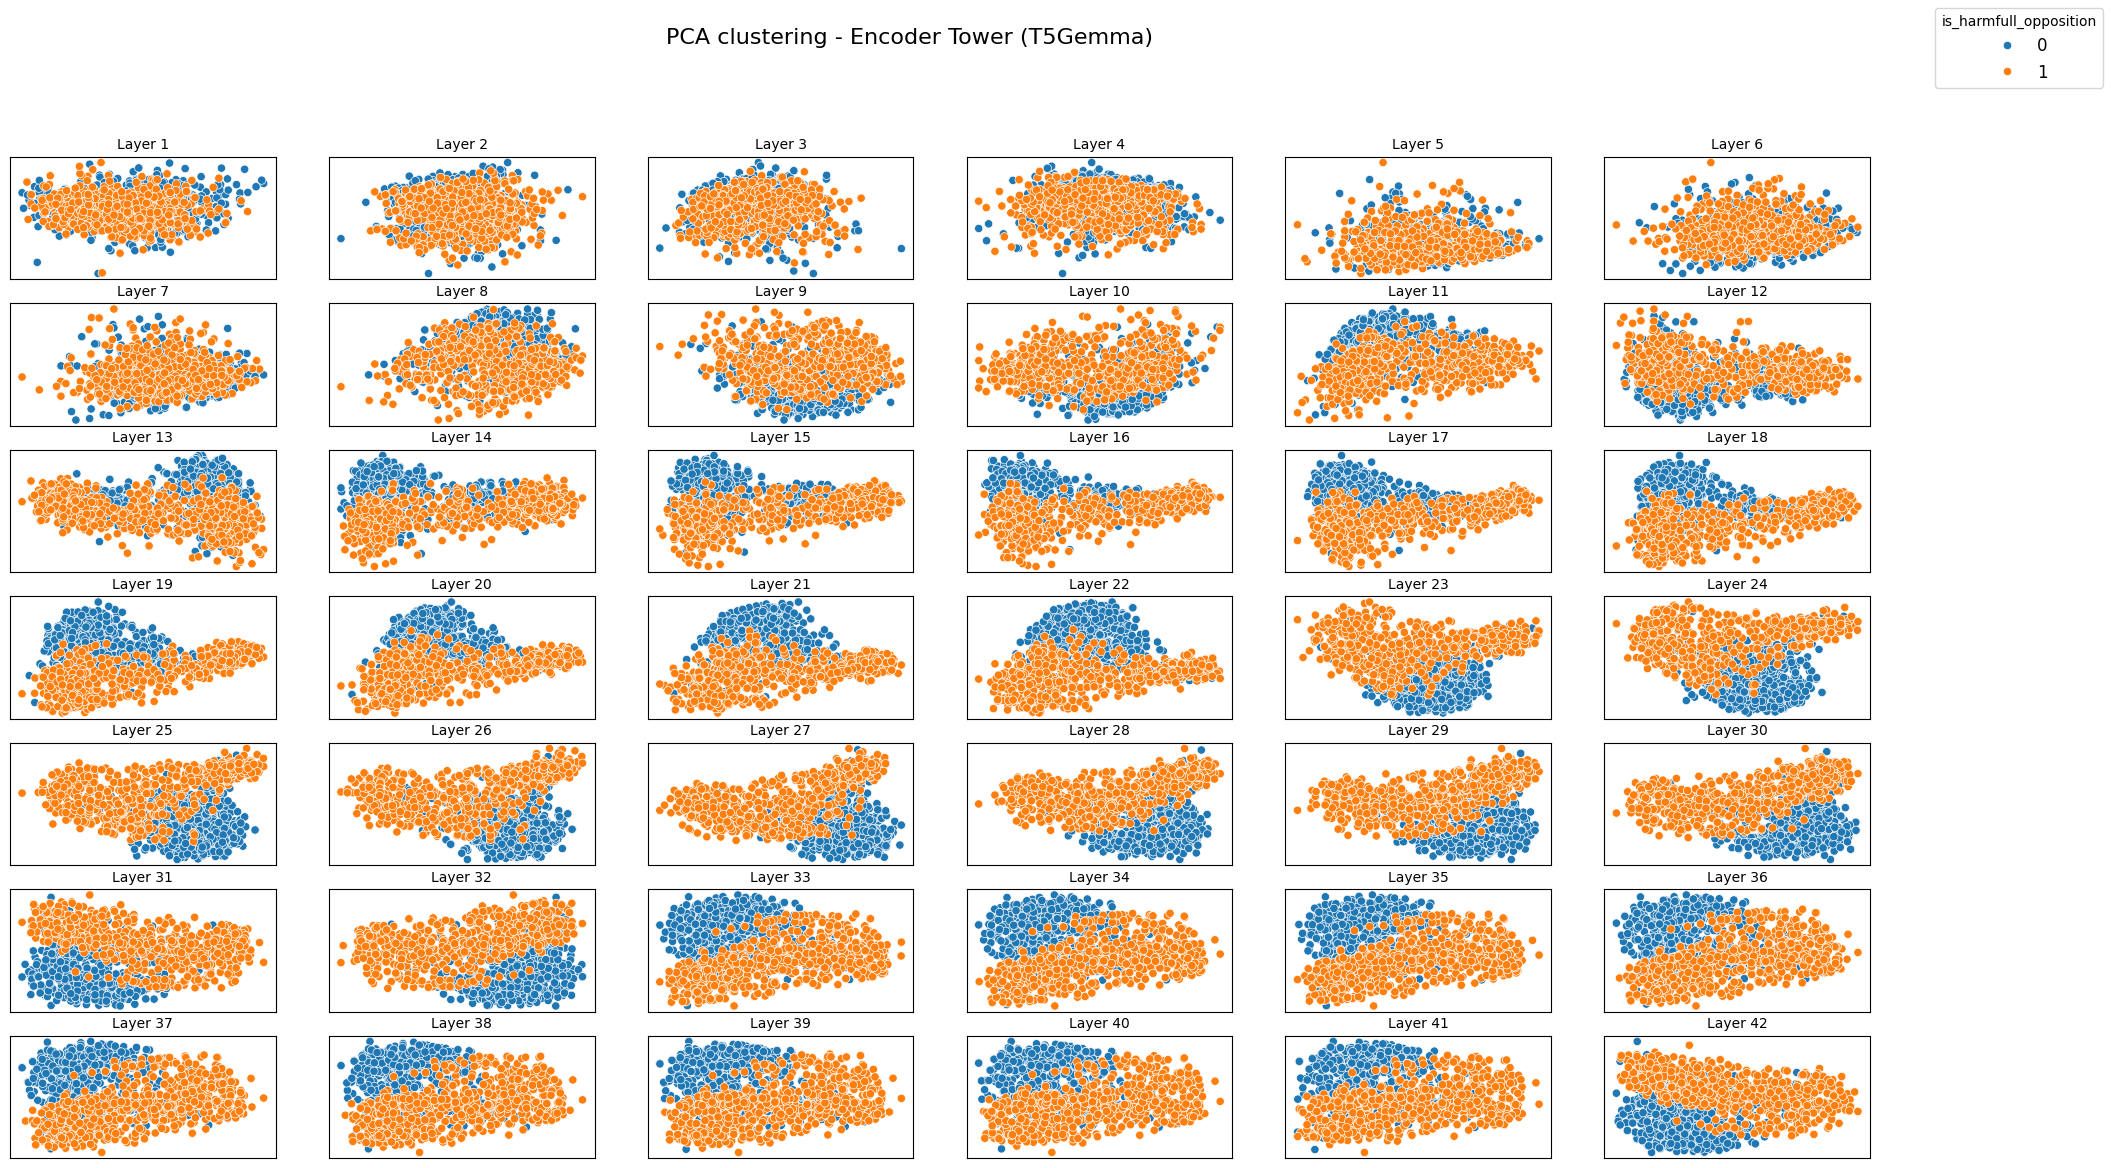

In [48]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑A. Encoder tower  (mean token works best)
# ──────────────────────────────────────────────────────────────────────────────
print("\n► Extracting *encoder* embeddings …")
X_pos_enc = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="enc_pos",
                                strategy="last-token",
                                use_decoder=False,
                                model=model,
                                tokenizer=tokenizer)

X_neg_enc = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="enc_neg",
                                strategy="last-token",
                                use_decoder=False,
                                model=model,
                                tokenizer=tokenizer)

# CHANGED: Convert GPU tensors to CPU numpy arrays for plotting
X_pos_enc = X_pos_enc.cpu().numpy()
X_neg_enc = X_neg_enc.cpu().numpy()

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_enc,
                           X_neg_enc,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Encoder Tower (T5Gemma)')

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑A. Encoder tower  (mean token works best)
# ──────────────────────────────────────────────────────────────────────────────
print("\n► Extracting *encoder* embeddings …")
X_pos_enc = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="enc_pos",
                                strategy="mean",
                                use_decoder=False,
                                model=model,
                                tokenizer=tokenizer)

X_neg_enc = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="enc_neg",
                                strategy="mean",
                                use_decoder=False,
                                model=model,
                                tokenizer=tokenizer)

# CHANGED: Convert GPU tensors to CPU numpy arrays for plotting
X_pos_enc = X_pos_enc.cpu().numpy()
X_neg_enc = X_neg_enc.cpu().numpy()

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_enc,
                           X_neg_enc,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Encoder Tower (T5Gemma)')


► Extracting *encoder* embeddings …


Processing batches (size=32): 100%|██████████| 39/39 [46:50<00:00, 72.08s/it]  


Batch extraction completed: shape=torch.Size([1244, 43, 3584]), device=cpu


Processing batches (size=32):  56%|█████▋    | 22/39 [26:13<21:23, 75.51s/it]  

In [ ]:
# # ──────────────────────────────────────────────────────────────────────────────
# # 4‑B. Decoder tower  (last token works best)
# # ──────────────────────────────────────────────────────────────────────────────
# print("\n► Extracting *decoder* embeddings …")
# X_pos_dec = embed_and_normalise(hate_total_yes_data['statement'],
#                                 tower_tag="dec_pos",
#                                 strategy="first-token",
#                                 use_decoder=True,
#                                 model=model,
#                                 tokenizer=tokenizer)

# X_neg_dec = embed_and_normalise(hate_total_no_data['statement'],
#                                 tower_tag="dec_neg",
#                                 strategy="first-token",
#                                 use_decoder=True,
#                                 model=model,
#                                 tokenizer=tokenizer)

# # CHANGED: Convert GPU tensors to CPU numpy arrays for plotting
# X_pos_dec = X_pos_dec.cpu().numpy()
# X_neg_dec = X_neg_dec.cpu().numpy()

# print("\n► Plotting PCA for *encoder* embeddings …")
# plot_pca_or_tsne_layerwise(X_pos_dec,
#                            X_neg_dec,
#                            hate_data['is_harmfull_opposition'],
#                            standardize=False, n_components=5,
#                            components=[0, 1], mode='pca',
#                            plot_title='PCA clustering - Decoder Tower (T5Gemma)')

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑B. Decoder tower  (last token works best)
# ──────────────────────────────────────────────────────────────────────────────
print("\n► Extracting *encoder* embeddings …")
X_pos_dec = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="dec_pos",
                                strategy="mean",
                                use_decoder=True,
                                model=model,
                                tokenizer=tokenizer)

X_neg_dec = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="dec_neg",
                                strategy="mean",
                                use_decoder=True,
                                model=model,
                                tokenizer=tokenizer)

# CHANGED: Convert GPU tensors to CPU numpy arrays for plotting
X_pos_dec = X_pos_dec.cpu().numpy()
X_neg_dec = X_neg_dec.cpu().numpy()

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_dec,
                           X_neg_dec,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Encoder Tower (T5Gemma)')

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑B. Decoder tower  (last token works best)
# ──────────────────────────────────────────────────────────────────────────────
print("\n► Extracting *encoder* embeddings …")
X_pos_dec = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="dec_pos",
                                strategy="last-token",
                                use_decoder=True,
                                model=model,
                                tokenizer=tokenizer)

X_neg_dec = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="dec_neg",
                                strategy="last-token",
                                use_decoder=True,
                                model=model,
                                tokenizer=tokenizer)

# CHANGED: Convert GPU tensors to CPU numpy arrays for plotting
X_pos_dec = X_pos_dec.cpu().numpy()
X_neg_dec = X_neg_dec.cpu().numpy()

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_dec,
                           X_neg_dec,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Encoder Tower (T5Gemma)')

## **5. Find best CCS**


To find the best layers, train CCS on all hidden states. You can use different normalization strategies, the best in experiments was l2 + median.

In [ ]:
import sys
import os

# Add the code directory directly to Python path
code_dir = '/Users/elenaericheva/ericheva_git/ccs_aisf/code'
if code_dir not in sys.path:
    sys.path.insert(0, code_dir)

print(f"Added {code_dir} to Python path")

import random, numpy as np, torch, pickle, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ccs import train_ccs_on_hidden_states
import pandas as pd


SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic, torch.backends.cudnn.benchmark = True, False

def run_ccs(X_pos_norm, X_neg_norm, *, tower_tag):
    # Train / test split once per tower
    idx              = np.arange(len(X_pos_norm))
    train_idx, test_idx = train_test_split(idx, test_size=0.2,
                                           random_state=71, shuffle=True)

    # CCS
    ccs_layers = train_ccs_on_hidden_states(X_pos_norm,
                                            X_neg_norm,
                                            hate_data['is_harmfull_opposition'],
                                            train_idx, test_idx,
                                            normalizing='median')

    # save
    with open(f'ccs_{YOUR_NAME}_{tower_tag}_mixed_results.pkl', 'wb') as f:
        pickle.dump(ccs_layers, f)

    # Accuracy curve
    acc = [layer_data['accuracy'] for layer_idx, layer_data in ccs_layers.items()]

    plt.figure(); plt.plot(acc); plt.title(f'CCS accuracy per layer ({tower_tag})')
    plt.xlabel('Layer'); plt.ylabel('Accuracy'); plt.show()

    # Best layer
    best_layer = int(np.argmax(acc))
    print(f'► Best {tower_tag} layer = {best_layer}  (acc={acc[best_layer]:.3f})')
    return best_layer

After that, we train the CCS on the selected layer to obtain the probe and its weights.

In [ ]:
# YOUR_NAME = "t5gemma-9b-9b-ul2"
# strategy = "first-token"
# hate_data = pd.read_csv('../data/raw/total_hate_data.csv', index_col=0)
# X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}.npz")['arr_0']
# X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}.npz")['arr_0']
# best_enc_layer = run_ccs(X_pos_enc, X_neg_enc, tower_tag=f'enc_{strategy}')

In [ ]:
YOUR_NAME = "t5gemma-9b-9b-ul2"
strategy = "last-token"
hate_data = pd.read_csv('../data/raw/total_hate_data.csv', index_col=0)
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}.npz")['arr_0']
best_enc_layer = run_ccs(X_pos_enc, X_neg_enc, tower_tag=f'enc_{strategy}')

In [ ]:
# YOUR_NAME = "t5gemma-9b-9b-ul2"
# strategy = "first-token"
# hate_data = pd.read_csv('../data/raw/total_hate_data.csv', index_col=0)
# X_pos_dec = np.load(f"{YOUR_NAME}_dec_pos_{strategy}.npz")['arr_0']
# X_neg_dec = np.load(f"{YOUR_NAME}_dec_neg_{strategy}.npz")['arr_0']
# best_dec_layer = run_ccs(X_pos_dec, X_neg_dec, tower_tag=f'dec_{strategy}')

In [ ]:
YOUR_NAME = "t5gemma-9b-9b-ul2"
strategy = "mean"    
hate_data = pd.read_csv('../data/raw/total_hate_data.csv', index_col=0)
X_pos_dec = np.load(f"{YOUR_NAME}_dec_pos_{strategy}.npz")['arr_0']
X_neg_dec = np.load(f"{YOUR_NAME}_dec_neg_{strategy}.npz")['arr_0']
best_dec_layer = run_ccs(X_pos_dec, X_neg_dec, tower_tag=f'dec_{strategy}')

In [ ]:
# !!!!!!!!!!
YOUR_NAME = "t5gemma-9b-9b-ul2"
strategy = "mean"
hate_data = pd.read_csv('../data/raw/total_hate_data.csv', index_col=0)
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}.npz")['arr_0']
best_enc_layer = run_ccs(X_pos_enc, X_neg_enc, tower_tag=f'enc_{strategy}')

In [ ]:
# !!!!
YOUR_NAME = "t5gemma-9b-9b-ul2"
strategy = "last-token"
hate_data = pd.read_csv('../data/raw/total_hate_data.csv', index_col=0)
X_pos_dec = np.load(f"{YOUR_NAME}_dec_pos_{strategy}.npz")['arr_0']
X_neg_dec = np.load(f"{YOUR_NAME}_dec_neg_{strategy}.npz")['arr_0']
best_dec_layer = run_ccs(X_pos_dec, X_neg_dec, tower_tag=f'dec_{strategy}')


In [ ]:
1/0

In [ ]:
from ccs import CCS
import pandas as pd, numpy as np, pickle
from sklearn.model_selection import train_test_split

def single_layer_ccs(X_pos_norm, X_neg_norm, best_layer, *, tower_tag):
    # Slice out the chosen layer
    X_pos_layer = pd.DataFrame(X_pos_norm[:, best_layer])
    X_neg_layer = pd.DataFrame(X_neg_norm[:, best_layer])

    idx = np.arange(len(X_pos_norm))
    train_idx, test_idx = train_test_split(idx, test_size=0.2,
                                           random_state=71, shuffle=True)

    # Train/test split
    X_pos_train = X_pos_layer.loc[train_idx].values.astype(np.float32)
    X_pos_test  = X_pos_layer.loc[test_idx].values.astype(np.float32)
    X_neg_train = X_neg_layer.loc[train_idx].values.astype(np.float32)
    X_neg_test  = X_neg_layer.loc[test_idx].values.astype(np.float32)

    y_train = hate_data['is_harmfull_opposition'][train_idx]
    y_test  = hate_data['is_harmfull_opposition'][test_idx]

    # Median normalise in‑place
    X_pos_train -= np.median(X_pos_train); X_pos_test -= np.median(X_pos_train)
    X_neg_train -= np.median(X_neg_train); X_neg_test -= np.median(X_neg_train)

    # CCS without labels (NEG first, then POS)
    ccs = CCS(X_neg_train, X_pos_train, y_train.values,
              var_normalize=False, lambda_classification=0,
              predict_normalize=False)
    ccs.repeated_train()

    acc = ccs.get_acc(X_neg_test, X_pos_test, y_test.values)
    print(f'CCS accuracy ({tower_tag}, layer {best_layer}) = {acc:.3f}')

    with open(f'ccs_{YOUR_NAME}_{tower_tag}_mixed_l{best_layer}.pkl', 'wb') as f:
        pickle.dump(ccs, f)


hate_data = pd.read_csv('../data/raw/total_hate_data.csv', index_col=0)
strategy = "mean"
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}.npz")['arr_0']
single_layer_ccs(X_pos_enc, X_neg_enc, best_enc_layer, tower_tag=f'enc_{strategy}')

# best_enc_layer = 11
# strategy = "first-token"
# X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}.npz")['arr_0']
# X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}.npz")['arr_0']
# single_layer_ccs(X_pos_enc, X_neg_enc, best_enc_layer, tower_tag=f'enc_{strategy}')

best_enc_layer = 18  # 25?
strategy = "last-token"
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}.npz")['arr_0']
single_layer_ccs(X_pos_enc, X_neg_enc, best_enc_layer, tower_tag=f'enc_{strategy}!!!!')

# print("")
# strategy = "first-token"
# X_pos_dec = np.load(f"{YOUR_NAME}_dec_pos_{strategy}.npz")['arr_0']
# X_neg_dec = np.load(f"{YOUR_NAME}_dec_neg_{strategy}.npz")['arr_0']
# single_layer_ccs(X_pos_dec, X_neg_dec, best_dec_layer, tower_tag=f'dec_{strategy}')

best_dec_layer = 18
strategy = "mean"
X_pos_dec = np.load(f"{YOUR_NAME}_dec_pos_{strategy}.npz")['arr_0']
X_neg_dec = np.load(f"{YOUR_NAME}_dec_neg_{strategy}.npz")['arr_0']
single_layer_ccs(X_pos_dec, X_neg_dec, best_dec_layer, tower_tag=f'dec_{strategy}')

best_dec_layer = 16  # 18?
strategy = "last-token"
X_pos_dec = np.load(f"{YOUR_NAME}_dec_pos_{strategy}.npz")['arr_0']
X_neg_dec = np.load(f"{YOUR_NAME}_dec_neg_{strategy}.npz")['arr_0']
single_layer_ccs(X_pos_dec, X_neg_dec, best_dec_layer, tower_tag=f'dec_{strategy}!!!!')


# NOT

In [ ]:
import torch
import pandas as pd
import numpy as np
from extract_fixed_t5gemma import vectorize_df
from format_results_fixed import plot_pca_or_tsne_layerwise


# ──────────────────────────────────────────────────────────────────────────────
# 2. Load your datasets
# ──────────────────────────────────────────────────────────────────────────────

hate_data           = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
hate_total_yes_data = pd.read_csv('../data/yes_no/hate_total3.0_yes.csv', index_col=0)
hate_total_no_data  = pd.read_csv('../data/yes_no/hate_total3.0_no.csv',  index_col=0)

# ──────────────────────────────────────────────────────────────────────────────
# 3. Helper to run vectorise‑>save‑>normalise in one go
# ──────────────────────────────────────────────────────────────────────────────
from extract_fixed_t5gemma9b import vectorize_df_batched

def embed_and_normalise(df_text, tower_tag, strategy, use_decoder, model, tokenizer):
    """Returns L2‑normalised (n_samples, n_layers, dim) GPU tensor"""
    # CHANGED: Use GPU device and return GPU tensor
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # CHANGED: Use batched processing
    X = vectorize_df_batched(
        df_text,
        model, tokenizer,
        strategy=strategy,
        model_type="encoder-decoder",
        use_decoder=use_decoder,
        get_all_hs=True,
        device=device,
        batch_size=32,  # Increased batch size
        max_length=64  # Reduced max length for speed
    )

    # CHANGED: Save CPU version but keep GPU tensor for return
    np.savez_compressed(f"{YOUR_NAME}_{tower_tag}_{strategy}.npz", X.cpu().numpy())

    # CHANGED: L2-normalize on GPU
    X_flat = X.view(-1, X.shape[-1])
    X_norm = torch.nn.functional.normalize(X_flat, p=2, dim=1).view(X.shape)

    # CHANGED: Save normalized version
    # np.savez_compressed(f"{YOUR_NAME}_{tower_tag}_{strategy}_norm.npz", X_norm.cpu().numpy())
    return X_norm  # CHANGED: Return GPU tensor








In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑A. Encoder tower  (mean token works best)
# ──────────────────────────────────────────────────────────────────────────────
print("\n► Extracting *encoder* embeddings …")
X_pos_enc = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="enc_pos",
                                strategy="first-token",
                                use_decoder=False,
                                model=model,
                                tokenizer=tokenizer)

X_neg_enc = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="enc_neg",
                                strategy="first-token",
                                use_decoder=False,
                                model=model,
                                tokenizer=tokenizer)

# CHANGED: Convert GPU tensors to CPU numpy arrays for plotting
X_pos_enc = X_pos_enc.cpu().numpy()
X_neg_enc = X_neg_enc.cpu().numpy()

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_enc,
                           X_neg_enc,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Encoder Tower (T5Gemma)')

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑A. Encoder tower  (mean token works best)
# ──────────────────────────────────────────────────────────────────────────────
print("\n► Extracting *encoder* embeddings …")
X_pos_enc = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="enc_pos",
                                strategy="last-token",
                                use_decoder=False,
                                model=model,
                                tokenizer=tokenizer)

X_neg_enc = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="enc_neg",
                                strategy="last-token",
                                use_decoder=False,
                                model=model,
                                tokenizer=tokenizer)

# CHANGED: Convert GPU tensors to CPU numpy arrays for plotting
X_pos_enc = X_pos_enc.cpu().numpy()
X_neg_enc = X_neg_enc.cpu().numpy()

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_enc,
                           X_neg_enc,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Encoder Tower (T5Gemma)')

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑A. Encoder tower  (mean token works best)
# ──────────────────────────────────────────────────────────────────────────────
print("\n► Extracting *encoder* embeddings …")
X_pos_enc = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="enc_pos",
                                strategy="mean",
                                use_decoder=False,
                                model=model,
                                tokenizer=tokenizer)

X_neg_enc = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="enc_neg",
                                strategy="mean",
                                use_decoder=False,
                                model=model,
                                tokenizer=tokenizer)

# CHANGED: Convert GPU tensors to CPU numpy arrays for plotting
X_pos_enc = X_pos_enc.cpu().numpy()
X_neg_enc = X_neg_enc.cpu().numpy()

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_enc,
                           X_neg_enc,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Encoder Tower (T5Gemma)')

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑B. Decoder tower  (last token works best)
# ──────────────────────────────────────────────────────────────────────────────
print("\n► Extracting *decoder* embeddings …")
X_pos_dec = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="dec_pos",
                                strategy="first-token",
                                use_decoder=True,
                                model=model,
                                tokenizer=tokenizer)

X_neg_dec = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="dec_neg",
                                strategy="first-token",
                                use_decoder=True,
                                model=model,
                                tokenizer=tokenizer)

# CHANGED: Convert GPU tensors to CPU numpy arrays for plotting
X_pos_dec = X_pos_dec.cpu().numpy()
X_neg_dec = X_neg_dec.cpu().numpy()

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_dec,
                           X_neg_dec,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Decoder Tower (T5Gemma)')

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑B. Decoder tower  (last token works best)
# ──────────────────────────────────────────────────────────────────────────────
print("\n► Extracting *encoder* embeddings …")
X_pos_dec = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="dec_pos",
                                strategy="mean",
                                use_decoder=True,
                                model=model,
                                tokenizer=tokenizer)

X_neg_dec = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="dec_neg",
                                strategy="mean",
                                use_decoder=True,
                                model=model,
                                tokenizer=tokenizer)

# CHANGED: Convert GPU tensors to CPU numpy arrays for plotting
X_pos_dec = X_pos_dec.cpu().numpy()
X_neg_dec = X_neg_dec.cpu().numpy()

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_dec,
                           X_neg_dec,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Decoder Tower (T5Gemma)')

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑B. Decoder tower  (last token works best)
# ──────────────────────────────────────────────────────────────────────────────
print("\n► Extracting *encoder* embeddings …")
X_pos_dec = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="dec_pos",
                                strategy="last-token",
                                use_decoder=True,
                                model=model,
                                tokenizer=tokenizer)

X_neg_dec = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="dec_neg",
                                strategy="last-token",
                                use_decoder=True,
                                model=model,
                                tokenizer=tokenizer)

# CHANGED: Convert GPU tensors to CPU numpy arrays for plotting
X_pos_dec = X_pos_dec.cpu().numpy()
X_neg_dec = X_neg_dec.cpu().numpy()

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_dec,
                           X_neg_dec,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Decoder Tower (T5Gemma)')

In [ ]:
# Add the code directory directly to Python path
code_dir = '/Users/elenaericheva/ericheva_git/ccs_aisf/code'
if code_dir not in sys.path:
    sys.path.insert(0, code_dir)

print(f"Added {code_dir} to Python path")

import random, numpy as np, torch, pickle, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ccs import train_ccs_on_hidden_states
import sys
import os
import pandas as pd


SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic, torch.backends.cudnn.benchmark = True, False

def run_ccs(X_pos_norm, X_neg_norm, *, tower_tag):
    # Train / test split once per tower
    idx              = np.arange(len(X_pos_norm))
    train_idx, test_idx = train_test_split(idx, test_size=0.2,
                                           random_state=71, shuffle=True)

    # CCS
    ccs_layers = train_ccs_on_hidden_states(X_pos_norm,
                                            X_neg_norm,
                                            hate_data['is_harmfull_opposition'],
                                            train_idx, test_idx,
                                            normalizing='median')

    # save
    with open(f'ccs_{YOUR_NAME}_{tower_tag}_not_results.pkl', 'wb') as f:
        pickle.dump(ccs_layers, f)

    # Accuracy curve
    acc = [layer_data['accuracy'] for layer_idx, layer_data in ccs_layers.items()]
    plt.figure(); plt.plot(acc); plt.title(f'CCS accuracy per layer ({tower_tag})')
    plt.xlabel('Layer'); plt.ylabel('Accuracy'); plt.show()

    # Best layer
    best_layer = int(np.argmax(acc))
    print(f'► Best {tower_tag} layer = {best_layer}  (acc={acc[best_layer]:.3f})')
    return best_layer

# best_enc_layer = run_ccs(X_pos_enc, X_neg_enc, tower_tag='enc')


In [ ]:
YOUR_NAME = "t5gemma-9b-9b-ul2"
strategy = "first-token"
hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}_not.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}_not.npz")['arr_0']
best_enc_layer = run_ccs(X_pos_enc, X_neg_enc, tower_tag=f'enc_{strategy}')

In [ ]:
YOUR_NAME = "t5gemma-9b-9b-ul2"
strategy = "last-token"
hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}_not.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}_not.npz")['arr_0']
best_enc_layer = run_ccs(X_pos_enc, X_neg_enc, tower_tag=f'enc_{strategy}')

In [ ]:
YOUR_NAME = "t5gemma-9b-9b-ul2"
strategy = "first-token"
hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
X_pos_dec = np.load(f"{YOUR_NAME}_dec_pos_{strategy}_not.npz")['arr_0']
X_neg_dec = np.load(f"{YOUR_NAME}_dec_neg_{strategy}_not.npz")['arr_0']
best_enc_layer = run_ccs(X_pos_dec, X_neg_dec, tower_tag=f'dec_{strategy}')

In [ ]:
YOUR_NAME = "t5gemma-9b-9b-ul2"
strategy = "mean"
hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
X_pos_dec = np.load(f"{YOUR_NAME}_dec_pos_{strategy}_not.npz")['arr_0']
X_neg_dec = np.load(f"{YOUR_NAME}_dec_neg_{strategy}_not.npz")['arr_0']
best_dec_layer = run_ccs(X_pos_dec, X_neg_dec, tower_tag=f'dec_{strategy}')

In [ ]:
# !!!!!!!!
YOUR_NAME = "t5gemma-9b-9b-ul2"
strategy = "mean"
hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}_not.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}_not.npz")['arr_0']
best_enc_layer = run_ccs(X_pos_enc, X_neg_enc, tower_tag=f'enc_{strategy}')

In [ ]:
# !!!!!!!!!
YOUR_NAME = "t5gemma-9b-9b-ul2"
strategy = "last-token"
hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
X_pos_dec = np.load(f"{YOUR_NAME}_dec_pos_{strategy}_not.npz")['arr_0']
X_neg_dec = np.load(f"{YOUR_NAME}_dec_neg_{strategy}_not.npz")['arr_0']
best_dec_layer = run_ccs(X_pos_dec, X_neg_dec, tower_tag=f'dec_{strategy}')


In [ ]:
1/0

In [ ]:
from ccs import CCS
import pandas as pd, numpy as np, pickle
from sklearn.model_selection import train_test_split

def single_layer_ccs(X_pos_norm, X_neg_norm, best_layer, *, tower_tag):
    # Slice out the chosen layer
    X_pos_layer = pd.DataFrame(X_pos_norm[:, best_layer])
    X_neg_layer = pd.DataFrame(X_neg_norm[:, best_layer])

    idx = np.arange(len(X_pos_norm))
    train_idx, test_idx = train_test_split(idx, test_size=0.2,
                                           random_state=71, shuffle=True)

    # Train/test split
    X_pos_train = X_pos_layer.loc[train_idx].values.astype(np.float32)
    X_pos_test  = X_pos_layer.loc[test_idx].values.astype(np.float32)
    X_neg_train = X_neg_layer.loc[train_idx].values.astype(np.float32)
    X_neg_test  = X_neg_layer.loc[test_idx].values.astype(np.float32)

    y_train = hate_data['is_harmfull_opposition'][train_idx]
    y_test  = hate_data['is_harmfull_opposition'][test_idx]

    # Median normalise in‑place
    X_pos_train -= np.median(X_pos_train); X_pos_test -= np.median(X_pos_train)
    X_neg_train -= np.median(X_neg_train); X_neg_test -= np.median(X_neg_train)

    # CCS without labels (NEG first, then POS)
    ccs = CCS(X_neg_train, X_pos_train, y_train.values,
              var_normalize=False, lambda_classification=0,
              predict_normalize=False)
    ccs.repeated_train()

    acc = ccs.get_acc(X_neg_test, X_pos_test, y_test.values)
    print(f'CCS accuracy ({tower_tag}, layer {best_layer}) = {acc:.3f}')

    with open(f'ccs_{YOUR_NAME}_{tower_tag}_not_l{best_layer}.pkl', 'wb') as f:
        pickle.dump(ccs, f)

hate_data = pd.read_csv('../data/raw/total_hate3.0.csv.csv', index_col=0)
strategy = "mean"
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}_not.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}_not.npz")['arr_0']
single_layer_ccs(X_pos_enc, X_neg_enc, best_enc_layer, tower_tag=f'enc_{strategy}')
strategy = "first-token"
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}_not.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}_not.npz")['arr_0']
single_layer_ccs(X_pos_enc, X_neg_enc, best_enc_layer, tower_tag=f'enc_{strategy}')

best_enc_layer = 21
strategy = "last-token"
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}_not.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}_not.npz")['arr_0']
single_layer_ccs(X_pos_enc, X_neg_enc, best_enc_layer, tower_tag=f'enc_{strategy}!!!!')

print("")
strategy = "first-token"
X_pos_dec = np.load(f"{YOUR_NAME}_dec_pos_{strategy}_not.npz")['arr_0']
X_neg_dec = np.load(f"{YOUR_NAME}_dec_neg_{strategy}_not.npz")['arr_0']
single_layer_ccs(X_pos_dec, X_neg_dec, best_dec_layer, tower_tag=f'dec_{strategy}')
strategy = "mean"
X_pos_dec = np.load(f"{YOUR_NAME}_dec_pos_{strategy}_not.npz")['arr_0']
X_neg_dec = np.load(f"{YOUR_NAME}_dec_neg_{strategy}_not.npz")['arr_0']
single_layer_ccs(X_pos_dec, X_neg_dec, best_dec_layer, tower_tag=f'dec_{strategy}')

best_dec_layer = 16
strategy = "last-token"
X_pos_dec = np.load(f"{YOUR_NAME}_dec_pos_{strategy}_not.npz")['arr_0']
X_neg_dec = np.load(f"{YOUR_NAME}_dec_neg_{strategy}_not.npz")['arr_0']
single_layer_ccs(X_pos_dec, X_neg_dec, best_dec_layer, tower_tag=f'dec_{strategy}!!!!')


# TTT

In [ ]:
import torch
import pandas as pd
import numpy as np
from extract_fixed_t5gemma import vectorize_df
from format_results_fixed import plot_pca_or_tsne_layerwise


# ──────────────────────────────────────────────────────────────────────────────
# 2. Load your datasets
# ──────────────────────────────────────────────────────────────────────────────

hate_data           = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
hate_total_yes_data = pd.read_csv('../data/yes_no/hate_total3.0_yes.csv', index_col=0)
hate_total_no_data  = pd.read_csv('../data/yes_no/hate_total3.0_no.csv',  index_col=0)

hate_total_yes_data['statement'] = hate_total_yes_data['statement'].apply(
                                    lambda x: x.replace('not', 'ttt').replace('Not', 'ttt'))
hate_total_no_data['statement'] = hate_total_no_data['statement'].apply(
                                        lambda x: x.replace('not', 'ttt').replace('Not', 'ttt'))

# ──────────────────────────────────────────────────────────────────────────────
# 3. Helper to run vectorise‑>save‑>normalise in one go
# ──────────────────────────────────────────────────────────────────────────────
from extract_fixed_t5gemma9b import vectorize_df_batched

def embed_and_normalise(df_text, tower_tag, strategy, use_decoder, model, tokenizer):
    """Returns L2‑normalised (n_samples, n_layers, dim) GPU tensor"""
    # CHANGED: Use GPU device and return GPU tensor
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # CHANGED: Use batched processing
    X = vectorize_df_batched(
        df_text,
        model, tokenizer,
        strategy=strategy,
        model_type="encoder-decoder",
        use_decoder=use_decoder,
        get_all_hs=True,
        device=device,
        batch_size=32,  # Increased batch size
        max_length=64  # Reduced max length for speed
    )

    # CHANGED: Save CPU version but keep GPU tensor for return
    np.savez_compressed(f"{YOUR_NAME}_{tower_tag}_{strategy}.npz", X.cpu().numpy())

    # CHANGED: L2-normalize on GPU
    X_flat = X.view(-1, X.shape[-1])
    X_norm = torch.nn.functional.normalize(X_flat, p=2, dim=1).view(X.shape)

    # CHANGED: Save normalized version
    # np.savez_compressed(f"{YOUR_NAME}_{tower_tag}_{strategy}_norm.npz", X_norm.cpu().numpy())
    return X_norm  # CHANGED: Return GPU tensor








In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑A. Encoder tower  (mean token works best)
# ──────────────────────────────────────────────────────────────────────────────
print("\n► Extracting *encoder* embeddings …")
X_pos_enc = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="enc_pos",
                                strategy="first-token",
                                use_decoder=False,
                                model=model,
                                tokenizer=tokenizer)

X_neg_enc = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="enc_neg",
                                strategy="first-token",
                                use_decoder=False,
                                model=model,
                                tokenizer=tokenizer)

# CHANGED: Convert GPU tensors to CPU numpy arrays for plotting
X_pos_enc = X_pos_enc.cpu().numpy()
X_neg_enc = X_neg_enc.cpu().numpy()

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_enc,
                           X_neg_enc,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Encoder Tower (T5Gemma)')

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑A. Encoder tower  (mean token works best)
# ──────────────────────────────────────────────────────────────────────────────
print("\n► Extracting *encoder* embeddings …")
X_pos_enc = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="enc_pos",
                                strategy="last-token",
                                use_decoder=False,
                                model=model,
                                tokenizer=tokenizer)

X_neg_enc = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="enc_neg",
                                strategy="last-token",
                                use_decoder=False,
                                model=model,
                                tokenizer=tokenizer)

# CHANGED: Convert GPU tensors to CPU numpy arrays for plotting
X_pos_enc = X_pos_enc.cpu().numpy()
X_neg_enc = X_neg_enc.cpu().numpy()

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_enc,
                           X_neg_enc,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Encoder Tower (T5Gemma)')

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑A. Encoder tower  (mean token works best)
# ──────────────────────────────────────────────────────────────────────────────
print("\n► Extracting *encoder* embeddings …")
X_pos_enc = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="enc_pos",
                                strategy="mean",
                                use_decoder=False,
                                model=model,
                                tokenizer=tokenizer)

X_neg_enc = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="enc_neg",
                                strategy="mean",
                                use_decoder=False,
                                model=model,
                                tokenizer=tokenizer)

# CHANGED: Convert GPU tensors to CPU numpy arrays for plotting
X_pos_enc = X_pos_enc.cpu().numpy()
X_neg_enc = X_neg_enc.cpu().numpy()

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_enc,
                           X_neg_enc,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Encoder Tower (T5Gemma)')

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑B. Decoder tower  (last token works best)
# ──────────────────────────────────────────────────────────────────────────────
print("\n► Extracting *decoder* embeddings …")
X_pos_dec = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="dec_pos",
                                strategy="first-token",
                                use_decoder=True,
                                model=model,
                                tokenizer=tokenizer)

X_neg_dec = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="dec_neg",
                                strategy="first-token",
                                use_decoder=True,
                                model=model,
                                tokenizer=tokenizer)

# CHANGED: Convert GPU tensors to CPU numpy arrays for plotting
X_pos_dec = X_pos_dec.cpu().numpy()
X_neg_dec = X_neg_dec.cpu().numpy()

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_dec,
                           X_neg_dec,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Decoder Tower (T5Gemma)')

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑B. Decoder tower  (last token works best)
# ──────────────────────────────────────────────────────────────────────────────
print("\n► Extracting *encoder* embeddings …")
X_pos_dec = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="dec_pos",
                                strategy="mean",
                                use_decoder=True,
                                model=model,
                                tokenizer=tokenizer)

X_neg_dec = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="dec_neg",
                                strategy="mean",
                                use_decoder=True,
                                model=model,
                                tokenizer=tokenizer)

# CHANGED: Convert GPU tensors to CPU numpy arrays for plotting
X_pos_dec = X_pos_dec.cpu().numpy()
X_neg_dec = X_neg_dec.cpu().numpy()

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_dec,
                           X_neg_dec,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Decoder Tower (T5Gemma)')

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4‑B. Decoder tower  (last token works best)
# ──────────────────────────────────────────────────────────────────────────────
print("\n► Extracting *encoder* embeddings …")
X_pos_dec = embed_and_normalise(hate_total_yes_data['statement'],
                                tower_tag="dec_pos",
                                strategy="last-token",
                                use_decoder=True,
                                model=model,
                                tokenizer=tokenizer)

X_neg_dec = embed_and_normalise(hate_total_no_data['statement'],
                                tower_tag="dec_neg",
                                strategy="last-token",
                                use_decoder=True,
                                model=model,
                                tokenizer=tokenizer)

# CHANGED: Convert GPU tensors to CPU numpy arrays for plotting
X_pos_dec = X_pos_dec.cpu().numpy()
X_neg_dec = X_neg_dec.cpu().numpy()

print("\n► Plotting PCA for *encoder* embeddings …")
plot_pca_or_tsne_layerwise(X_pos_dec,
                           X_neg_dec,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering - Decoder Tower (T5Gemma)')

In [ ]:
import sys
import os

# Add the code directory directly to Python path
code_dir = '/Users/elenaericheva/ericheva_git/ccs_aisf/code'
if code_dir not in sys.path:
    sys.path.insert(0, code_dir)

print(f"Added {code_dir} to Python path")

import random, numpy as np, torch, pickle, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ccs import train_ccs_on_hidden_states
import pandas as pd

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic, torch.backends.cudnn.benchmark = True, False

def run_ccs(X_pos_norm, X_neg_norm, *, tower_tag):
    # Train / test split once per tower
    idx              = np.arange(len(X_pos_norm))
    train_idx, test_idx = train_test_split(idx, test_size=0.2,
                                           random_state=71, shuffle=True)

    # CCS
    ccs_layers = train_ccs_on_hidden_states(X_pos_norm,
                                            X_neg_norm,
                                            hate_data['is_harmfull_opposition'],
                                            train_idx, test_idx,
                                            normalizing='median')

    # save
    with open(f'ccs_{YOUR_NAME}_{tower_tag}_ttt_results.pkl', 'wb') as f:
        pickle.dump(ccs_layers, f)

    # Accuracy curve
    acc = [layer_data['accuracy'] for layer_idx, layer_data in ccs_layers.items()]
    plt.figure(); plt.plot(acc); plt.title(f'CCS accuracy per layer ({tower_tag})')
    plt.xlabel('Layer'); plt.ylabel('Accuracy'); plt.show()

    # Best layer
    best_layer = int(np.argmax(acc))
    print(f'► Best {tower_tag} layer = {best_layer}  (acc={acc[best_layer]:.3f})')
    return best_layer

# best_enc_layer = run_ccs(X_pos_enc, X_neg_enc, tower_tag='enc')


In [ ]:
YOUR_NAME = "t5gemma-9b-9b-ul2"
strategy = "first-token"
hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}_ttt.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}_ttt.npz")['arr_0']
best_enc_layer = run_ccs(X_pos_enc, X_neg_enc, tower_tag=f'enc_{strategy}')

In [ ]:
YOUR_NAME = "t5gemma-9b-9b-ul2"
strategy = "last-token"
hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}_ttt.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}_ttt.npz")['arr_0']
best_enc_layer = run_ccs(X_pos_enc, X_neg_enc, tower_tag=f'enc_{strategy}')

In [ ]:
YOUR_NAME = "t5gemma-9b-9b-ul2"
strategy = "first-token"
hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
X_pos_dec = np.load(f"{YOUR_NAME}_dec_pos_{strategy}_ttt.npz")['arr_0']
X_neg_dec = np.load(f"{YOUR_NAME}_dec_neg_{strategy}_ttt.npz")['arr_0']
best_dec_layer = run_ccs(X_pos_dec, X_neg_dec, tower_tag=f'dec_{strategy}')

In [ ]:
YOUR_NAME = "t5gemma-9b-9b-ul2"
strategy = "mean"
hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
X_pos_dec = np.load(f"{YOUR_NAME}_dec_pos_{strategy}_ttt.npz")['arr_0']
X_neg_dec = np.load(f"{YOUR_NAME}_dec_neg_{strategy}_ttt.npz")['arr_0']
best_dec_layer = run_ccs(X_pos_dec, X_neg_dec, tower_tag=f'dec_{strategy}')

In [ ]:
# !!!!!!!!
YOUR_NAME = "t5gemma-9b-9b-ul2"
strategy = "first-token"
hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}_ttt.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}_ttt.npz")['arr_0']
best_enc_layer = run_ccs(X_pos_enc, X_neg_enc, tower_tag=f'enc_{strategy}')

In [ ]:
# !!!!!!!!
YOUR_NAME = "t5gemma-9b-9b-ul2"
strategy = "last-token"
hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
X_pos_dec = np.load(f"{YOUR_NAME}_dec_pos_{strategy}_ttt.npz")['arr_0']
X_neg_dec = np.load(f"{YOUR_NAME}_dec_neg_{strategy}_ttt.npz")['arr_0']
best_dec_layer = run_ccs(X_pos_dec, X_neg_dec, tower_tag=f'dec_{strategy}')

In [ ]:
1/0

In [ ]:
from ccs import CCS
import pandas as pd, numpy as np, pickle
from sklearn.model_selection import train_test_split

def single_layer_ccs(X_pos_norm, X_neg_norm, best_layer, *, tower_tag):
    # Slice out the chosen layer
    X_pos_layer = pd.DataFrame(X_pos_norm[:, best_layer])
    X_neg_layer = pd.DataFrame(X_neg_norm[:, best_layer])

    idx = np.arange(len(X_pos_norm))
    train_idx, test_idx = train_test_split(idx, test_size=0.2,
                                           random_state=71, shuffle=True)

    # Train/test split
    X_pos_train = X_pos_layer.loc[train_idx].values.astype(np.float32)
    X_pos_test  = X_pos_layer.loc[test_idx].values.astype(np.float32)
    X_neg_train = X_neg_layer.loc[train_idx].values.astype(np.float32)
    X_neg_test  = X_neg_layer.loc[test_idx].values.astype(np.float32)

    y_train = hate_data['is_harmfull_opposition'][train_idx]
    y_test  = hate_data['is_harmfull_opposition'][test_idx]

    # Median normalise in‑place
    X_pos_train -= np.median(X_pos_train); X_pos_test -= np.median(X_pos_train)
    X_neg_train -= np.median(X_neg_train); X_neg_test -= np.median(X_neg_train)

    # CCS without labels (NEG first, then POS)
    ccs = CCS(X_neg_train, X_pos_train, y_train.values,
              var_normalize=False, lambda_classification=0,
              predict_normalize=False)
    ccs.repeated_train()

    acc = ccs.get_acc(X_neg_test, X_pos_test, y_test.values)
    print(f'CCS accuracy ({tower_tag}, layer {best_layer}) = {acc:.3f}')

    with open(f'ccs_{YOUR_NAME}_{tower_tag}_ttt_l{best_layer}.pkl', 'wb') as f:
        pickle.dump(ccs, f)

hate_data = pd.read_csv('../data/raw/total_hate3.0.csv.csv', index_col=0)
strategy = "mean"
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}_ttt.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}_ttt.npz")['arr_0']
single_layer_ccs(X_pos_enc, X_neg_enc, best_enc_layer, tower_tag=f'enc_{strategy}')
strategy = "first-token"
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}_ttt.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}_ttt.npz")['arr_0']
single_layer_ccs(X_pos_enc, X_neg_enc, best_enc_layer, tower_tag=f'enc_{strategy}')

best_enc_layer = 18
strategy = "last-token"
X_pos_enc = np.load(f"{YOUR_NAME}_enc_pos_{strategy}_ttt.npz")['arr_0']
X_neg_enc = np.load(f"{YOUR_NAME}_enc_neg_{strategy}_ttt.npz")['arr_0']
single_layer_ccs(X_pos_enc, X_neg_enc, best_enc_layer, tower_tag=f'enc_{strategy}!!!!')

print("")
strategy = "first-token"
X_pos_dec = np.load(f"{YOUR_NAME}_dec_pos_{strategy}_ttt.npz")['arr_0']
X_neg_dec = np.load(f"{YOUR_NAME}_dec_neg_{strategy}_ttt.npz")['arr_0']
single_layer_ccs(X_pos_dec, X_neg_dec, best_dec_layer, tower_tag=f'dec_{strategy}')
strategy = "mean"
X_pos_dec = np.load(f"{YOUR_NAME}_dec_pos_{strategy}_ttt.npz")['arr_0']
X_neg_dec = np.load(f"{YOUR_NAME}_dec_neg_{strategy}_ttt.npz")['arr_0']
single_layer_ccs(X_pos_dec, X_neg_dec, best_dec_layer, tower_tag=f'dec_{strategy}')

best_dec_layer = 16
strategy = "last-token"
X_pos_dec = np.load(f"{YOUR_NAME}_dec_pos_{strategy}_ttt.npz")['arr_0']
X_neg_dec = np.load(f"{YOUR_NAME}_dec_neg_{strategy}_ttt.npz")['arr_0']
single_layer_ccs(X_pos_dec, X_neg_dec, best_dec_layer, tower_tag=f'dec_{strategy}!!!!')



## **7. Plot results tables.**

In [ ]:
from format_results import get_results_table
orig_ccs_data = get_results_table(orig_ccs)

In [ ]:
fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(orig_ccs_data['accuracy'], label='Orig_CCS')

plt.hlines(1, 0, 7, label='ideal', colors='red', linewidth=3, linestyles=['--'])

plt.xlabel('Layer_number')
plt.ylabel('accuracy score ')
plt.legend(loc='upper right');

In [ ]:
from format_results import get_results_table
orig_ccs_data = get_results_table(orig_ccs)

fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(orig_ccs_data['contradiction idx ↓'], label='Orig_CCS')

plt.hlines(0, 0, 7, label='ideal', colors='red', linewidth=3, linestyles=['--'])

plt.xlabel('Layer_number')
plt.ylabel('Contradiction idx score ')
plt.legend(loc='upper right');

In [ ]:
fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(orig_ccs_data['agreement_score ↓'], label='Orig_CCS')

plt.hlines(0, 0, 7, label='ideal', colors='red', linewidth=3, linestyles=['--'])

plt.xlabel('Layer_number')
plt.ylabel('Agreement score ')
plt.legend(loc='upper right');